# Download Dataset

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aliszafar","key":"53caf611caab9332c62cc7e2be4c7e2f"}'}

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# !ln -s /content/gdrive/My\ Drive/ /mydrive

Mounted at /content/gdrive


In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download -d bulentsiyah/semantic-drone-dataset
! mkdir aerial-drone-ds
! ls
! unzip semantic-drone-dataset.zip -d aerial-drone-ds
! pip install -q segmentation-models-pytorch
! pip install -q torchsummary

%cd aerial-drone-ds

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                      5MB  2022-11-13 15:47:17           7596        232  1.0              
madhurpant/world-deaths-and-causes-1990-2019                    World Deaths and Causes (1990 - 2019)               442KB  2022-11-29 07:09:27           1469         36  1.0              
thedevastator/jobs-dataset-from-glassdoor                       Salary Prediction                                     3MB  2022-11-16 13:52:31           4902        109  1.0              
thedevastator/how-much-sleep-do-americans-really-get        

# Importing Library

In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm
from random import randrange

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
pwd = %pwd

# Preprocessing

In [6]:
IMAGE_PATH = pwd + '/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = pwd + '/dataset/semantic_drone_dataset/label_images_semantic/'

In [7]:
n_classes = 20 

def create_df_from_img_path(IMAGE_PATH):
    img_name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
          name = filename.split('.')[0]
          img_name.append(name)
    
    return pd.DataFrame({'id': img_name}, index = np.arange(0, len(img_name)))

img_df = create_df_from_img_path(IMAGE_PATH)
img_df.head()

,id
0,331
1,463
2,226
3,298
4,272


### Splitting in Training, Validation, Testing dataset

In [8]:
X_trainval, X_test = train_test_split(img_df['id'].values, test_size=0.1, random_state=19)
X_train, X_valid = train_test_split(X_trainval, test_size=0.2, random_state=19)

print(f'Train Img Size : {len(X_train)} images')
print(f'Validataion Img Size   :  {len(X_valid)} images')
print(f'Test Img Size  :  {len(X_test)} images')


Train Img Size : 288 images
Validataion Img Size   :  72 images
Test Img Size  :  40 images


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


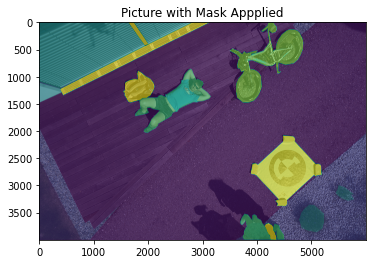

In [9]:
sample_img_index = randrange(img_df.size)

img = Image.open(IMAGE_PATH + img_df.iloc[sample_img_index].values[0] + '.jpg')
mask = Image.open(MASK_PATH + img_df.iloc[sample_img_index].values[0] + '.png')

print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)

plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

### Augmeting Dataset

In [10]:
class CustomImageDataset(Dataset):
    def __init__(self,
                 img_path,
                 mask_path,
                 X,
                 transform=None,
                 target_transform=None,
                 ):
      
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is None:
            img = Image.fromarray(img)
        else:
          aug = self.transform(image=img, mask=mask)
          img = Image.fromarray(aug['image'])
          mask = aug['mask']
        
        t = T.Compose([T.ToTensor()])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        return img, mask

In [11]:
# Creating Augmented Images
train_tensor = A.Compose([
                    A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     ])

validation_tensor = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
training_tensor_ds = CustomImageDataset(IMAGE_PATH, MASK_PATH, X_train, train_tensor,)
validation_tensor_ds = CustomImageDataset(IMAGE_PATH, MASK_PATH, X_valid, validation_tensor)
#dataloader
batch_size= 3 

train_loader = DataLoader(training_tensor_ds, batch_size=batch_size, shuffle=True)
validataion_loader = DataLoader(validation_tensor_ds, batch_size=batch_size, shuffle=True)               

In [12]:
print('Training Tensor DS Type: ', type(train_loader))
print(train_loader)
print('\n##############################################################################\n')
print('Training Tensor DS Type: ', type(train_loader))
print(train_loader)

Training Tensor DS Type:  <class 'torch.utils.data.dataloader.DataLoader'>

##############################################################################

Training Tensor DS Type:  <class 'torch.utils.data.dataloader.DataLoader'>


### Visualizing Augmented Dataset

Feature batch shape: torch.Size([3, 704, 1056])
Labels batch shape: torch.Size([704, 1056])


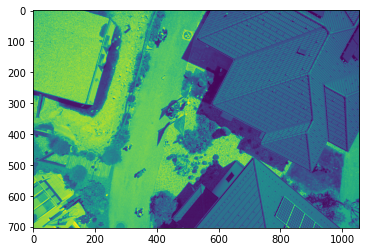

Label: tensor([4, 4, 4,  ..., 9, 9, 0])
Feature batch shape: torch.Size([3, 704, 1056])
Labels batch shape: torch.Size([704, 1056])


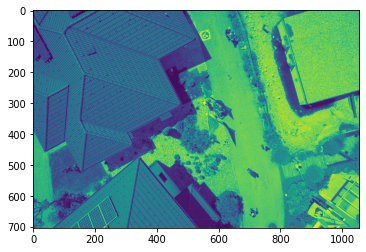

Label: tensor([0, 9, 9,  ..., 4, 4, 4])
Feature batch shape: torch.Size([3, 704, 1056])
Labels batch shape: torch.Size([704, 1056])


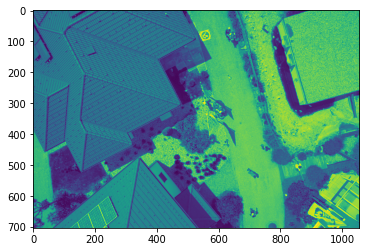

Label: tensor([0, 9, 9,  ..., 4, 4, 4])


In [13]:
def display_augmented_img():
  for i in range(3):
    train_features, train_labels = next(iter(training_tensor_ds))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")
    img = train_features[i].squeeze()
    label = train_labels[i]
    plt.imshow(img)
    plt.show()
    print(f"Label: {label}")

display_augmented_img()

# Model

Support functions for model training

In [14]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [15]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=20):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [16]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [41]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    decrease = 1 
    min_loss = np.inf

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
          
    
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))

            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
        if e % 3 == 0:
          print('saving model...')
          torch.save(model, model_sel+'-'+encoder_model+'epoch:'+str(e+1)+'.pt')
        #   print('Model saved as: '+model_sel+'-'+encoder_model+'epoch:'+str(e+1)+'.pt')    
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

Plotting functions for training summary

In [42]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot(history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()


### DeeplabV3 (Resnet 34)

In [74]:
model_sel='deeplabv3'
# model_sel='unet'
# model_sel='pspn'
encoder_model = 'resnet34'
# encoder_model = 'resnet101'

In [75]:
if model_sel == 'deeplabv3':
  model = smp.DeepLabV3(encoder_model, 
                      encoder_weights='imagenet', 
                      classes=23, activation=None, 
                      encoder_depth=5, 
                      )
elif model_sel == 'unet':
  model = smp.Unet(encoder_model, encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
elif model_sel == 'pspn':
  model = smp.PSPNet(encoder_name='resnet34', encoder_weights='imagenet', encoder_depth=5, psp_out_channels=512, psp_use_batchnorm=True, in_channels=3, classes=23, activation=None, upsampling=8, aux_params=None)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

### Model Training

In [76]:
max_lr = 1e-3
epoch = 25
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))
model_history = fit(epoch, model, train_loader, validataion_loader, criterion, optimizer, sched)
torch.save(model, model_sel+'-'+encoder_model+'epoch:'+str(epoch)+'.pt')
# !cp *.pt /mydrive/CPS_dataset/
# !ls /mydrive/CPS_dataset/

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

saving model...
Model saved as: deeplabv3-resnet34epoch:1.pt


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

saving model...
Model saved as: deeplabv3-resnet34epoch:4.pt


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

saving model...
Model saved as: deeplabv3-resnet34epoch:7.pt


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

saving model...
Model saved as: deeplabv3-resnet34epoch:10.pt


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

saving model...
Model saved as: deeplabv3-resnet34epoch:13.pt


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

saving model...
Model saved as: deeplabv3-resnet34epoch:16.pt


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

saving model...
Model saved as: deeplabv3-resnet34epoch:19.pt


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

saving model...
Model saved as: deeplabv3-resnet34epoch:22.pt


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

saving model...
Model saved as: deeplabv3-resnet34epoch:25.pt
Total time: 88.55 m
deeplabv3-resnet101epoch:10.pt	deeplabv3-resnet34epoch:13.pt
deeplabv3-resnet101epoch:12.pt	deeplabv3-resnet34epoch:16.pt
deeplabv3-resnet101epoch:13.pt	deeplabv3-resnet34epoch:19.pt
deeplabv3-resnet101epoch:16.pt	deeplabv3-resnet34epoch:1.pt
deeplabv3-resnet101epoch:19.pt	deeplabv3-resnet34epoch:22.pt
deeplabv3-resnet101epoch:1.pt	deeplabv3-resnet34epoch:25.pt
deeplabv3-resnet101epoch:20.pt	deeplabv3-resnet34epoch:3.pt
deeplabv3-resnet101epoch:22.pt	deeplabv3-resnet34epoch:4.pt
deeplabv3-resnet101epoch:25.pt	deeplabv3-resnet34epoch:7.pt
deeplabv3-resnet101epoch:3.pt	semantic_drone_dataset
deeplabv3-resnet101epoch:4.pt	semantic_drone_dataset_semantics_v1.1.zip
deeplabv3-resnet101epoch:7.pt	Unet-Resnet101.pt
deeplabv3-resnet34epoch:10.pt	Unet-Resnet.pt


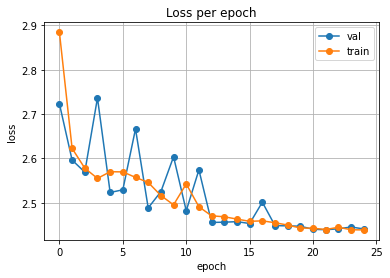

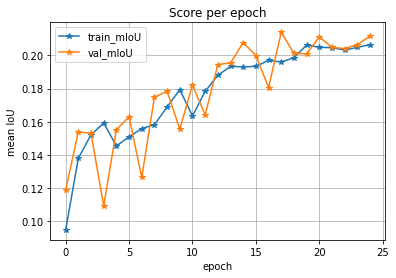

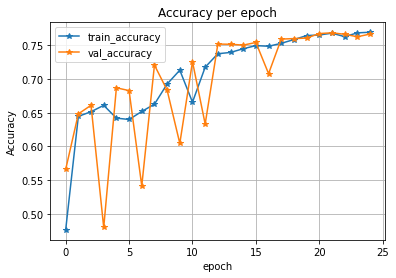

In [49]:
plot_loss(model_history)
plot_score(model_history)
plot_acc(model_history)

# Testset Evaluation

In [78]:
# model = torch.load('deeplabv3-resnet34epoch:16.pt')

In [79]:
class DroneTestDataset(Dataset):
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

Supporting functions for evaluations

In [80]:
def predict_image_mask_miou(model, image, mask):
    model.eval()
    t = T.Compose([T.ToTensor()])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [81]:
def predict_image_mask_pixel(model, image, mask,):
    model.eval()
    t = T.Compose([T.ToTensor()])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [82]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

/usr/local/lib/python3.8/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


In [83]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [84]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

In [85]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [86]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

# Results

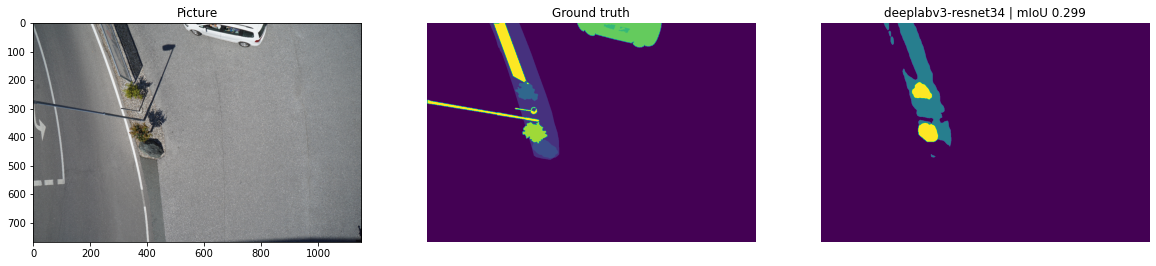

In [87]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture')

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title(model_sel+'-'+encoder_model+' | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

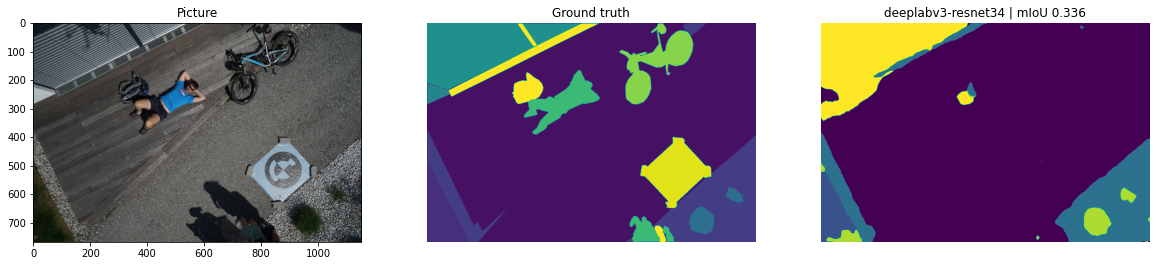

In [88]:
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture')

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title(model_sel+'-'+encoder_model+' | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

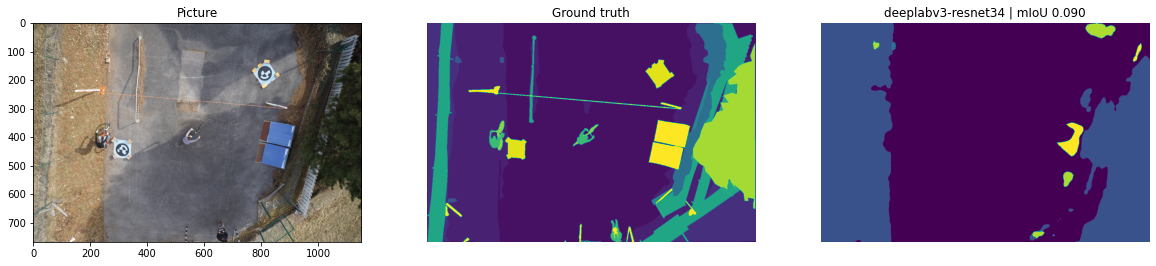

In [89]:
image3, mask3 = test_set[16]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture')

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title(model_sel+'-'+encoder_model+' | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [90]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.22874115502958192


In [91]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.7015009562174479


Please note, We have carried out model run two times before taking the best results among them. we haven't considered this result for our study. 